In [2]:
# %matplotlib notebook
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [7]:
#Global constants
DENSITY = 1
HEIGHT = 1
DIAMETER = 20
HEAT_CAPACITY = 1
COND_COEFF = 1
CONV_COEFF = 1
T_AMBIENT = 295
#Finite difference scheme
Nx = 50
Ny = 50
DX = DIAMETER/(Nx + 2)
DY = DIAMETER/(Ny + 2)
#Time integration
Total_time = 20

In [4]:
#BOUNDARY AND INITIAL CONDITIONS
T_initial = np.zeros((Nx, Ny), dtype=np.float64)
T_initial = T_initial + 290
    #perturbations
T_initial[Nx//2, Ny//2] += 10

In [5]:
#Basic finite differences
def foward_difference(T, dx, i, j, axis):
    if (i == Nx - 1) or (j == Ny - 1):
        return (T_AMBIENT - T[i, j])/dx
    elif axis == 1:
        return (T[i+1, j] - T[i, j])/dx
    elif axis == 2:
        return (T[i, j+1] - T[i, j])/dx
    
def backwards_difference(T, dx, i, j, axis):
    if (i == 0) or (j == 0):
        return (T[i,j] - T_AMBIENT)/dx
    elif axis == 1:
        return (T[i, j] - T[i-1, j])/dx
    elif axis == 2:
        return (T[i, j] - T[i, j-1])/dx

In [6]:
def pde_system(t, y):
    T = np.zeros_like(T_initial, dtype=np.float64)
    dTdt = np.zeros_like(T, dtype=np.float64)
    q_up = np.zeros_like(T, dtype=np.float64)
    q_down = np.zeros_like(T, dtype=np.float64)
    q_right = np.zeros_like(T, dtype=np.float64)
    q_left = np.zeros_like(T, dtype=np.float64)
    q_top = np.zeros_like(T, dtype=np.float64)

    for i in range(Ny):
        T[:,i] = y[Ny * i: Ny * (i+1)]

    for i in range(Nx):
        for j in range(Ny):
            
            q_up[i,j] = COND_COEFF * DX * HEIGHT * foward_difference(T, DY, i, j, axis=2)
            q_down[i,j] = COND_COEFF * DX * HEIGHT * backwards_difference(T, DY, i, j, axis=2)
            q_right[i,j] = COND_COEFF * HEIGHT * DY * foward_difference(T, DX, i, j, axis=1)
            q_left[i,j] = COND_COEFF * HEIGHT * DY * backwards_difference(T, DX, i, j, axis=1)
            q_top [i,j] = CONV_COEFF * DX * DY * (T_AMBIENT - T[i,j])

            dTdt[i,j] = 1/(DENSITY * HEAT_CAPACITY * DX * DY * HEIGHT) * ( q_up[i,j] + q_down[i,j] + q_right[i,j] + q_left[i,j] + q_top[i,j])
    
    # for i in range(Nx - 1):
    #     #Boundary at the bottom
    #     q_up[i,0] = COND_COEFF * DX * DY * foward_difference(T, DY, i, 0, axis=2)
    #     q_down[i,0] = COND_COEFF * DX * DY * (T[i,0] - T_AMBIENT)/DY
    #     q_right[i,0] = COND_COEFF * DX * DY * foward_difference(T, DX, i, 0, axis=1)
    #     q_left[i,0] = COND_COEFF * DX * DY * backwards_difference(T, DX, i, 0, axis=1)
    #     q_top [i,0] = CONV_COEFF * DX * DY * (T_AMBIENT - T[i,0])
    #     dTdt[i,0] = 1/(DENSITY * HEAT_CAPACITY * DX * DY * HEIGHT) * ( q_up[i,0] + q_down[i,0] + q_right[i,0] + q_left[i,0] + q_top[i,0])
    
    #     #Boundary at the top
    #     q_up[i,Ny - 1] = COND_COEFF * DX * DY * (T_AMBIENT - T[i,Ny - 1])/DY
    #     q_down[i,Ny - 1] = COND_COEFF * DX * DY * backwards_difference(T, DY, i, Ny - 1, axis=2)
    #     q_right[i,Ny - 1] = COND_COEFF * DX * DY * foward_difference(T, DX, i, Ny - 1, axis=1)
    #     q_left[i,Ny - 1] = COND_COEFF * DX * DY * backwards_difference(T, DX, i, Ny - 1, axis=1)
    #     q_top [i,Ny - 1] = CONV_COEFF * DX * DY * (T_AMBIENT - T[i,Ny - 1])        
    #     dTdt[i,Ny - 1] = 1/(DENSITY * HEAT_CAPACITY * DX * DY * HEIGHT) * ( q_up[i,Ny - 1] + q_down[i,Ny - 1] + q_right[i,Ny - 1] + q_left[i,Ny - 1] + q_top[i,Ny - 1])
        
    #     #Boundary at the left (Assuming DX = DY)
    #     q_up[0,i] = COND_COEFF * DX * DY * foward_difference(T, DY, 0, i, axis=2)
    #     q_down[0,i] = COND_COEFF * DX * DY * backwards_difference(T, DY, 0, i, axis=2)
    #     q_right[0,i] = COND_COEFF * DX * DY * foward_difference(T, DX, 0, i, axis=1)
    #     q_left[0,i] = COND_COEFF * DX * DY * (T[0,i] - T_AMBIENT)/DX
    #     q_top [0,i] = CONV_COEFF * DX * DY * (T_AMBIENT - T[0,i])


    #     #Boundary at the right (Assuming DX = DY)  
    #     q_up[Nx - 1,i] = COND_COEFF * DX * DY * foward_difference(T, DY, i, j, axis=2)
    #     q_down[Nx - 1,i] = COND_COEFF * DX * DY * backwards_difference(T, DY, i, j, axis=2)
    #     q_right[Nx - 1,i] = COND_COEFF * DX * DY * foward_difference(T, DX, i, j, axis=1)
    #     q_left[Nx - 1,0] = COND_COEFF * DX * DY * backwards_difference(T, DX, i, j, axis=1)
    #     q_top [Nx - 1,0] = CONV_COEFF * DX * DY * (T_AMBIENT - T[i,j])
    return dTdt.flatten()

In [8]:
t0 = 0
tf = Total_time
y0 = T_initial.flatten()
sol1 = solve_ivp(pde_system, t_span=(0,tf), y0=y0, method="RK45")

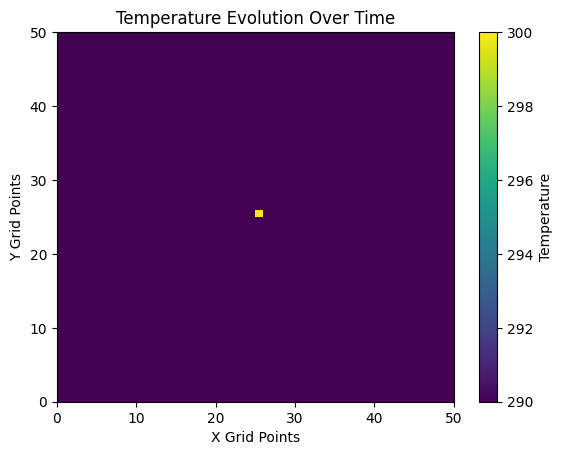

MovieWriter ffmpeg unavailable; using Pillow instead.


In [9]:
time_steps = len(sol1.t)
values = sol1.y.transpose()
values = values.reshape(time_steps, Ny, Nx)  # Reshape into (time_steps, Ny, Nx)

# Create the figure and axis
fig, ax = plt.subplots()
cax = ax.pcolormesh(values[0], shading='auto', cmap='viridis')  # Initial heatmap

# Add a colorbar to show the temperature scale
cbar = fig.colorbar(cax)
cbar.set_label('Temperature')

# Set up the plot title and labels
ax.set_title("Temperature Evolution Over Time")
ax.set_xlabel("X Grid Points")
ax.set_ylabel("Y Grid Points")

# Update function for the animation
def update(frame):
    cax.set_array(values[frame].flatten())  # Update the heatmap with the new time step
    ax.set_title(f"Temperature Evolution Over Time (Time step: {frame})")
    return cax,

# Create the animation
ani = FuncAnimation(fig, update, frames=time_steps, blit=False, interval=100)

# Display the animation
plt.show()

# Save the animation as a GIF (optional)
ani.save('temperature_evolution.gif', writer='ffmpeg', fps=30)